In [6]:
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as mpatches
import wandb
from rliable import library as rly
from matplotlib.patches import Patch
from rliable import metrics
from rliable import plot_utils
import seaborn as sns
import numpy as np
import os
from collections import OrderedDict
import matplotlib.ticker as ticker

from utils import *



In [7]:
plt.rcParams["legend.title_fontsize"] = "large"
plt.rcParams.update({'font.size': 35})

matplotlib.rc("xtick", labelsize=35)
matplotlib.rc("ytick", labelsize=35)

In [8]:
# Initialize the wandb API
api = wandb.Api()

# Define your project and entity (replace with your specific values)
entity = "cl-probing"  # e.g., your username or team name
figures_path = "./figures"
data_path = "./data"
os.makedirs(figures_path, exist_ok=True)
os.makedirs(data_path, exist_ok=True)
take_x_seeds = 10
window_size = 10
use_se = True
all_configs = []

## Generalized Stitching Configs

In [9]:
def generalized_grouping_func(config):
    result = ''
    if config['agent']['agent_name'] == 'gcdqn':
        result += 'GCDQN'
    elif config['agent']['agent_name'] == 'clearn_search':
        result += "C-LEARN"
    elif config['agent']['agent_name'] == 'gciql_search':
        result += "GCIQL"
    else:
        result += "CRL"

    if config['agent']['is_td']:
        result += ' TD'
    else:
        result += ' MC'

    if config['agent']['net_arch'] =='mlp':
        result += ' SMALL'
    else:
        result += ' BIG'


    return result

agents = ['GCDQN', 'C-LEARN', 'CRL', 'GCIQL']
grid_sizes = [5]


for grid_size in grid_sizes:

    config_1 = {
        "directory": "generalized",
        "title": f"scaling_generalized_train_3_boxes_2_movable_{grid_size}_grid_scatter",
        "projects":["paper_generalized"],
        "possible_names":[' '.join([agent, s]) for s in ['MC BIG', 'MC SMALL', 'TD BIG', 'TD SMALL'] for agent in agents],
        "filters":{
            # "config.agent.is_td": False,
            "config.env.grid_size": grid_size,
            "config.env.number_of_boxes_max":3,
            "config.env.number_of_moving_boxes_max":2,
        },
        "grouping_func": generalized_grouping_func,
        "metrics": OrderedDict([
            ("eval/mean_success", "Training success on 3 boxes \n(1 on target)"), 
            ("eval_3/mean_success", "Test success on 3 boxes \n(0 on target)"),
        ]),
    }


    all_configs.extend([config_1])


# Plotting

./figures


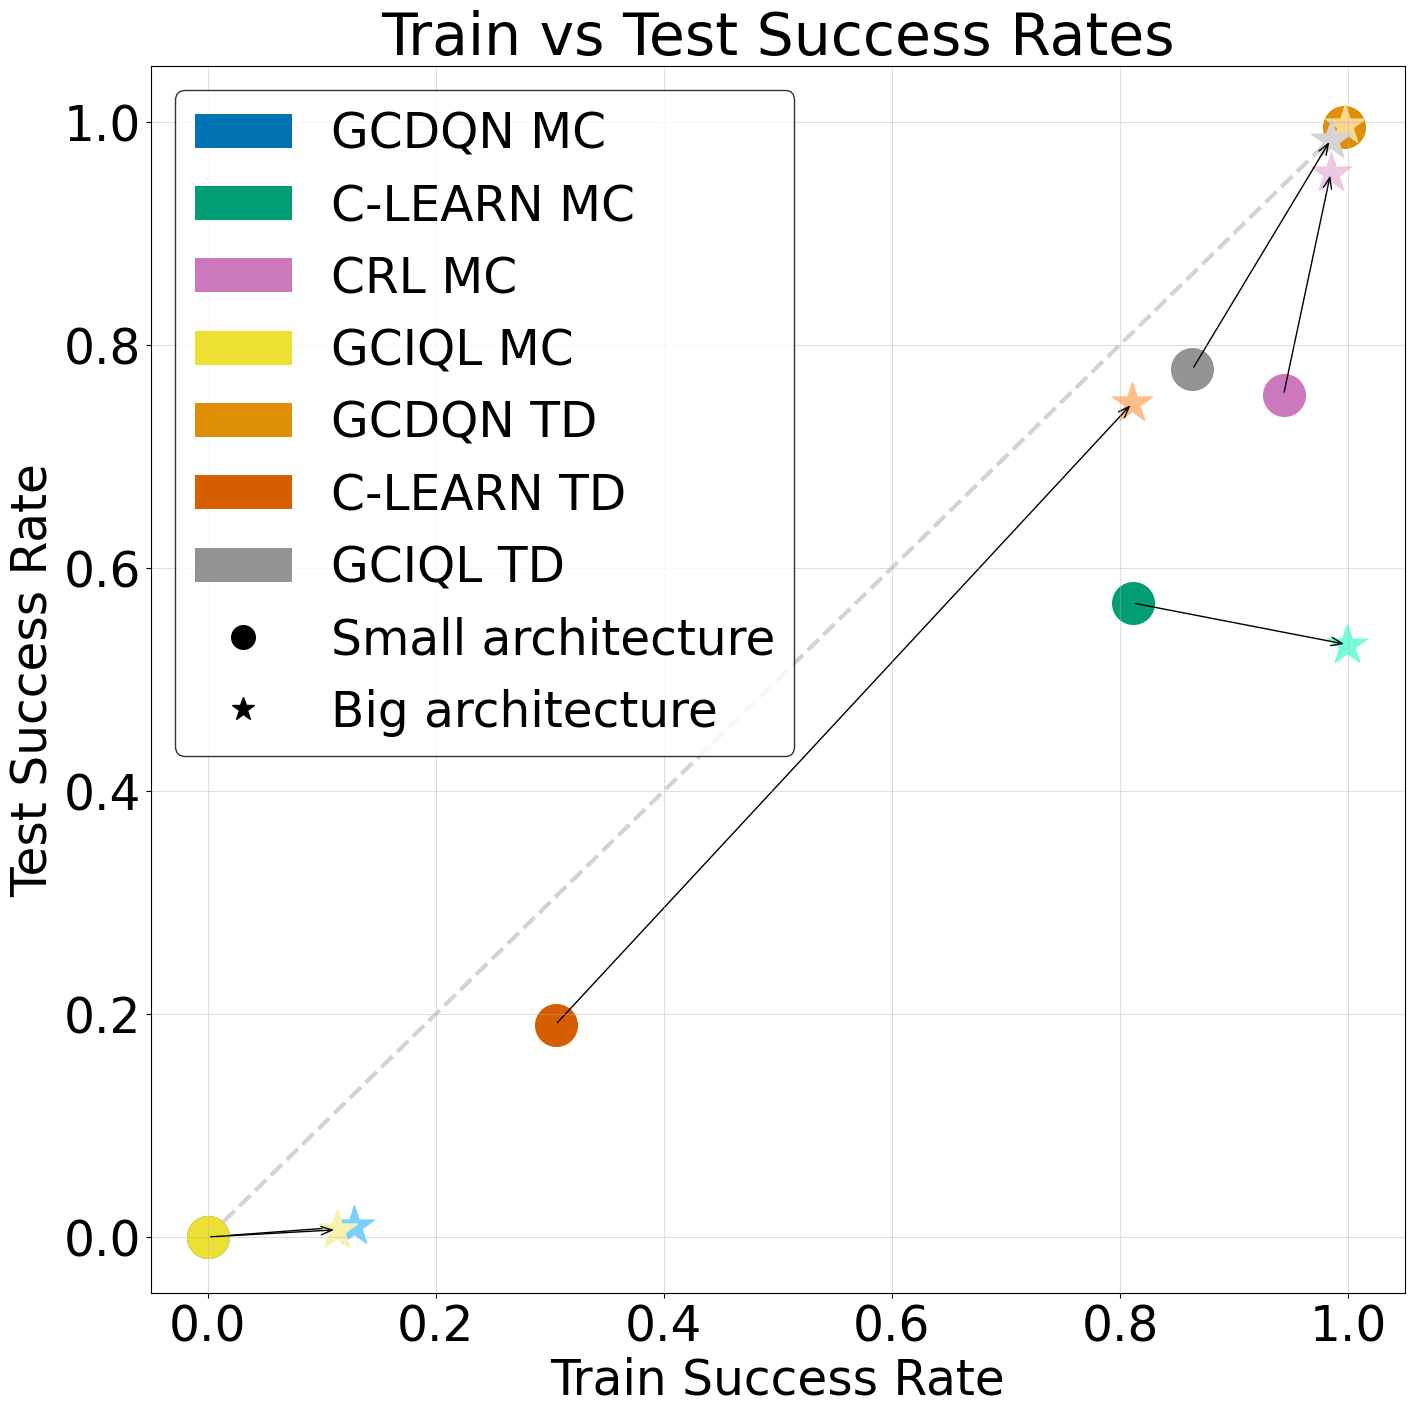

In [10]:
fig, ax = plt.subplots(figsize=(15, 15))
ax.plot([0, 1], [0, 1], linestyle='--', color='lightgray', lw=3, scalex=False, scaley=False, zorder=-100)


for config in all_configs:
    ax.set_title("Train vs Test Success Rates")
    runs = []
    for project in config['projects']:
        project_runs = api.runs(path=f"{entity}/{project}", filters=config['filters'])
        runs.extend([r for r in project_runs])


    # data = aggregate_data_from_wandb(runs, config['metrics'], config['possible_names'], config['grouping_func'], return_last_step=True)
    data_curves = aggregate_data_from_wandb(runs, config['metrics'], config['possible_names'], config['grouping_func'], return_last_step=False)


    empty_keys = []
    for k, v in data_curves.items():
        if v.size == 0:
            empty_keys.append(k)

    for k in empty_keys:
        del data_curves[k]

    new_data = OrderedDict()

    for k, v in data_curves.items():
        aggregated_v = np.mean(v[:, -5:, :], axis=1)
        new_data[k] = aggregated_v

    keys_to_del = []


    for k in keys_to_del:
        del new_data[k]


    names = list(new_data.keys())

    metrics_names = config['metrics']

    path = os.path.join(figures_path, config['directory'])
    os.makedirs(path, exist_ok=True)

    aggregate_func = lambda x: np.array([metrics.aggregate_iqm(x[:, i]) for i in range(x.shape[-1])])


    # fig, ax = plt.subplots()
    aggregate_scores, aggregate_scores_cis = rly.get_interval_estimates(
        new_data, aggregate_func, reps=500
    )

    actual_keys = [k for k in aggregate_scores.keys() if 'BIG' not in k]

    color_palette = sns.color_palette('colorblind')

    tick_pos = []
    labels = []
    ax.grid(True, axis='both', alpha=0.40)


    for idx, alg in enumerate(actual_keys):
        small_score = aggregate_scores[alg]
        small_cis = aggregate_scores_cis[alg]
        small_lower, small_upper = small_cis

        big_key = alg.replace('SMALL', 'BIG')
        big_score = aggregate_scores[big_key]
        big_cis = aggregate_scores_cis[big_key]
        big_lower, big_upper = big_cis

        center = 2.5 * idx + 0.5

        tick_pos.extend([center-0.5, center+0.5])
        small_color=return_color(alg, train=True)
        big_color=return_color(alg, train=False)
        label_name = alg.replace('SMALL', '')
        labels.extend([(label_name, small_color)])
        label_name = label_name.replace(' MC', '')
        label_name = label_name.replace(' TD', '')



        ax.scatter(*small_score, color=small_color, s=900)
        ax.scatter(*big_score, color=big_color, s=900, marker='*')

        diff = np.mean(big_score - small_score).item()

        if abs(diff) > 0.05:


            arr = mpatches.FancyArrowPatch(small_score, big_score,
                                arrowstyle='->,head_width=.15', mutation_scale=20)
            ax.add_patch(arr)

            # ax.annotate(f"+{diff:.2f}", (.4, .5), xycoords=arr, ha='center', va='center', fontsize=25)

    ax.set_xlabel("Train Success Rate")
    ax.set_ylabel("Test Success Rate")


legend_elements = [Patch(facecolor=c, label=l) for (l, c) in labels]
legend_elements.append(matplotlib.lines.Line2D([], [], color='black', marker='o', linestyle='None',markersize=17, label='Small architecture'))
legend_elements.append(matplotlib.lines.Line2D([], [], color='black', marker='*', linestyle='None',markersize=17, label='Big architecture'))
ax.legend(handles=legend_elements, edgecolor='black', loc='upper left')


    
title = all_configs[0]['title']
print(figures_path)
path = os.path.join(figures_path, 'scaling')
plt.tight_layout()
os.makedirs(path, exist_ok=True)
plt.savefig(os.path.join(path, f"{title}.png"),bbox_inches='tight')
plt.savefig(os.path.join(path, f"{title}.pdf"),bbox_inches='tight')